In [6]:
from IPython.display import Image
import numpy as np
import torch
from torch import nn

## basics

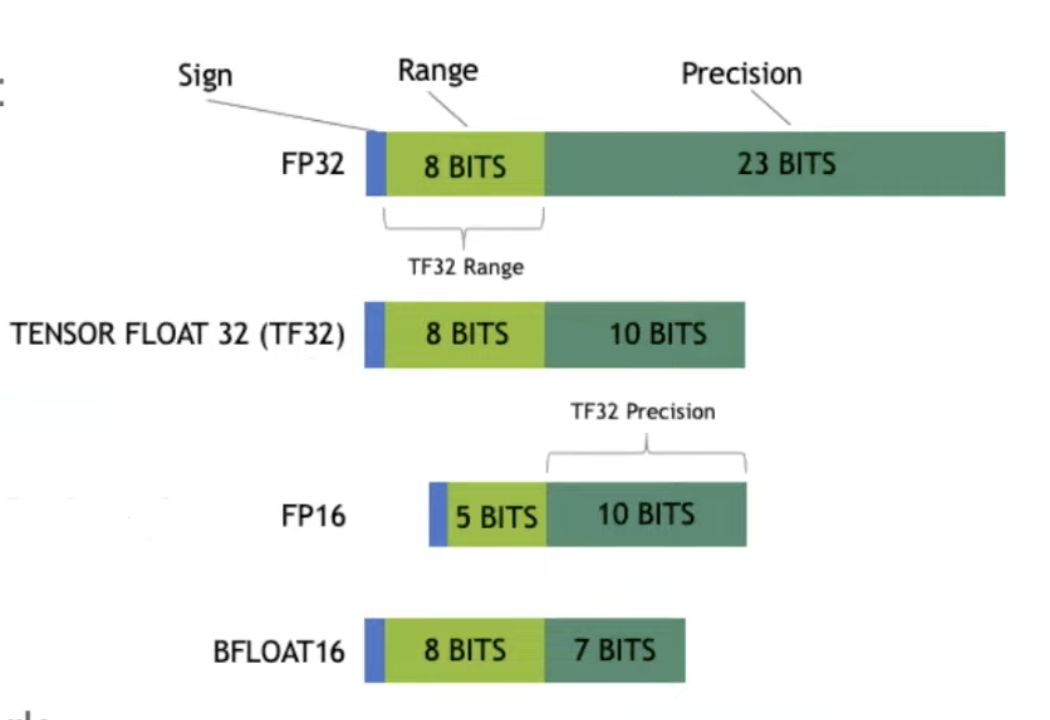

In [3]:
Image('../imgs/floats-rep.png', width=500)

- LLM.int8(): 8-bit Matrix Multiplication for Transformers at Scale
    - vector-wise quantization & mixed precision decomposition
    - https://arxiv.org/abs/2208.07339
- 作者也是开源库：bitsandbytes 的作者
    - https://github.com/TimDettmers/bitsandbytes
    - Tim Dettmers，也是 QLora 的作者
- emergent features
    - highly systematic emergent features in transformer language models that dominate attention and transformer
predictive performance.
    - emergent outliers vs. Regular values

### 简单过程展示

$$
y=\frac{x}{x_\max}\cdot 127\\
x = \frac{y\cdot x_\max}{127}
$$

In [53]:
a = torch.randn(5)
a

tensor([-1.2120, -1.1836,  0.9135,  0.3374, -2.0923])

In [54]:
a_max = torch.abs(a).max()
a_max

tensor(2.0923)

In [55]:
# a/a_max [-1, 1] ==> [-127, 127]
scaled = (a/a_max)*127
scaled

tensor([ -73.5643,  -71.8426,   55.4499,   20.4772, -127.0000])

In [56]:
# rounded
int8val = torch.round(scaled)
int8val

tensor([ -74.,  -72.,   55.,   20., -127.])

In [57]:
# rescaling
fp32val = int8val.float() * a_max / 127

In [58]:
torch.abs(fp32val - a).mean()

tensor(0.0050)

In [62]:
a = torch.randn(5)
a_max = torch.abs(a).max()
scaled = a/a_max * 127
int8val = torch.round(scaled)
fp32val = int8val * a_max / 127
print(a)
print(fp32val)
print(torch.mean(torch.abs(a - fp32val)))

tensor([ 1.2562, -1.9820,  0.8818,  0.1681,  2.4403])
tensor([ 1.2490, -1.9791,  0.8839,  0.1729,  2.4403])
tensor(0.0034)


### outliers 对量化的影响

- 异常值会显著地增加量化误差；

In [60]:
a = torch.randn(5)
# 手动地添加一个异常值
a[-1] = -5
a

tensor([ 1.5208,  2.6041, -1.6629,  1.0116, -5.0000])

In [66]:
a = torch.randn(5)
# 手动地添加一个异常值
a[-1] = -5
a_max = torch.abs(a).max()
scaled = a/a_max*127
int7val = torch.round(scaled)
fp32val = int7val * a_max / 127
print(a)
print(fp32val)
print(torch.mean(torch.abs(a - fp32val)))

tensor([ 1.8757, -1.0133,  0.9264,  0.2839, -5.0000])
tensor([ 1.8898, -1.0236,  0.9449,  0.2756, -5.0000])
tensor(0.0102)


## LLM.int8

### vector-wise quantization

- 每一个 vector（row vector/column vector）计算 normalization constant

$$
A@B=C\\
[b\times h] @ [h\times o]\rightarrow [b\times o]
$$

- A, B 都是 fp16，现在要做的是转化为 int8
- normailze A & B
    - 对于 A16
        - A: [b, h] => [b]
        - absmax_A_vec = A16.absmax(1)
        - A8 = A16/absmax_A_vec * 127
    - 对于 B16  
        - B: [b, o] => [o]
        - absmax_B_vec = B16.absmax(0)
        - B8 = B16/absmax_B_vec * 127
- 计算 C32 = A8 @ B8
- C16f = C32 \* (absmax_A_vec @ absmax_B_vec) / (127\*127) 

## 一个计算示例

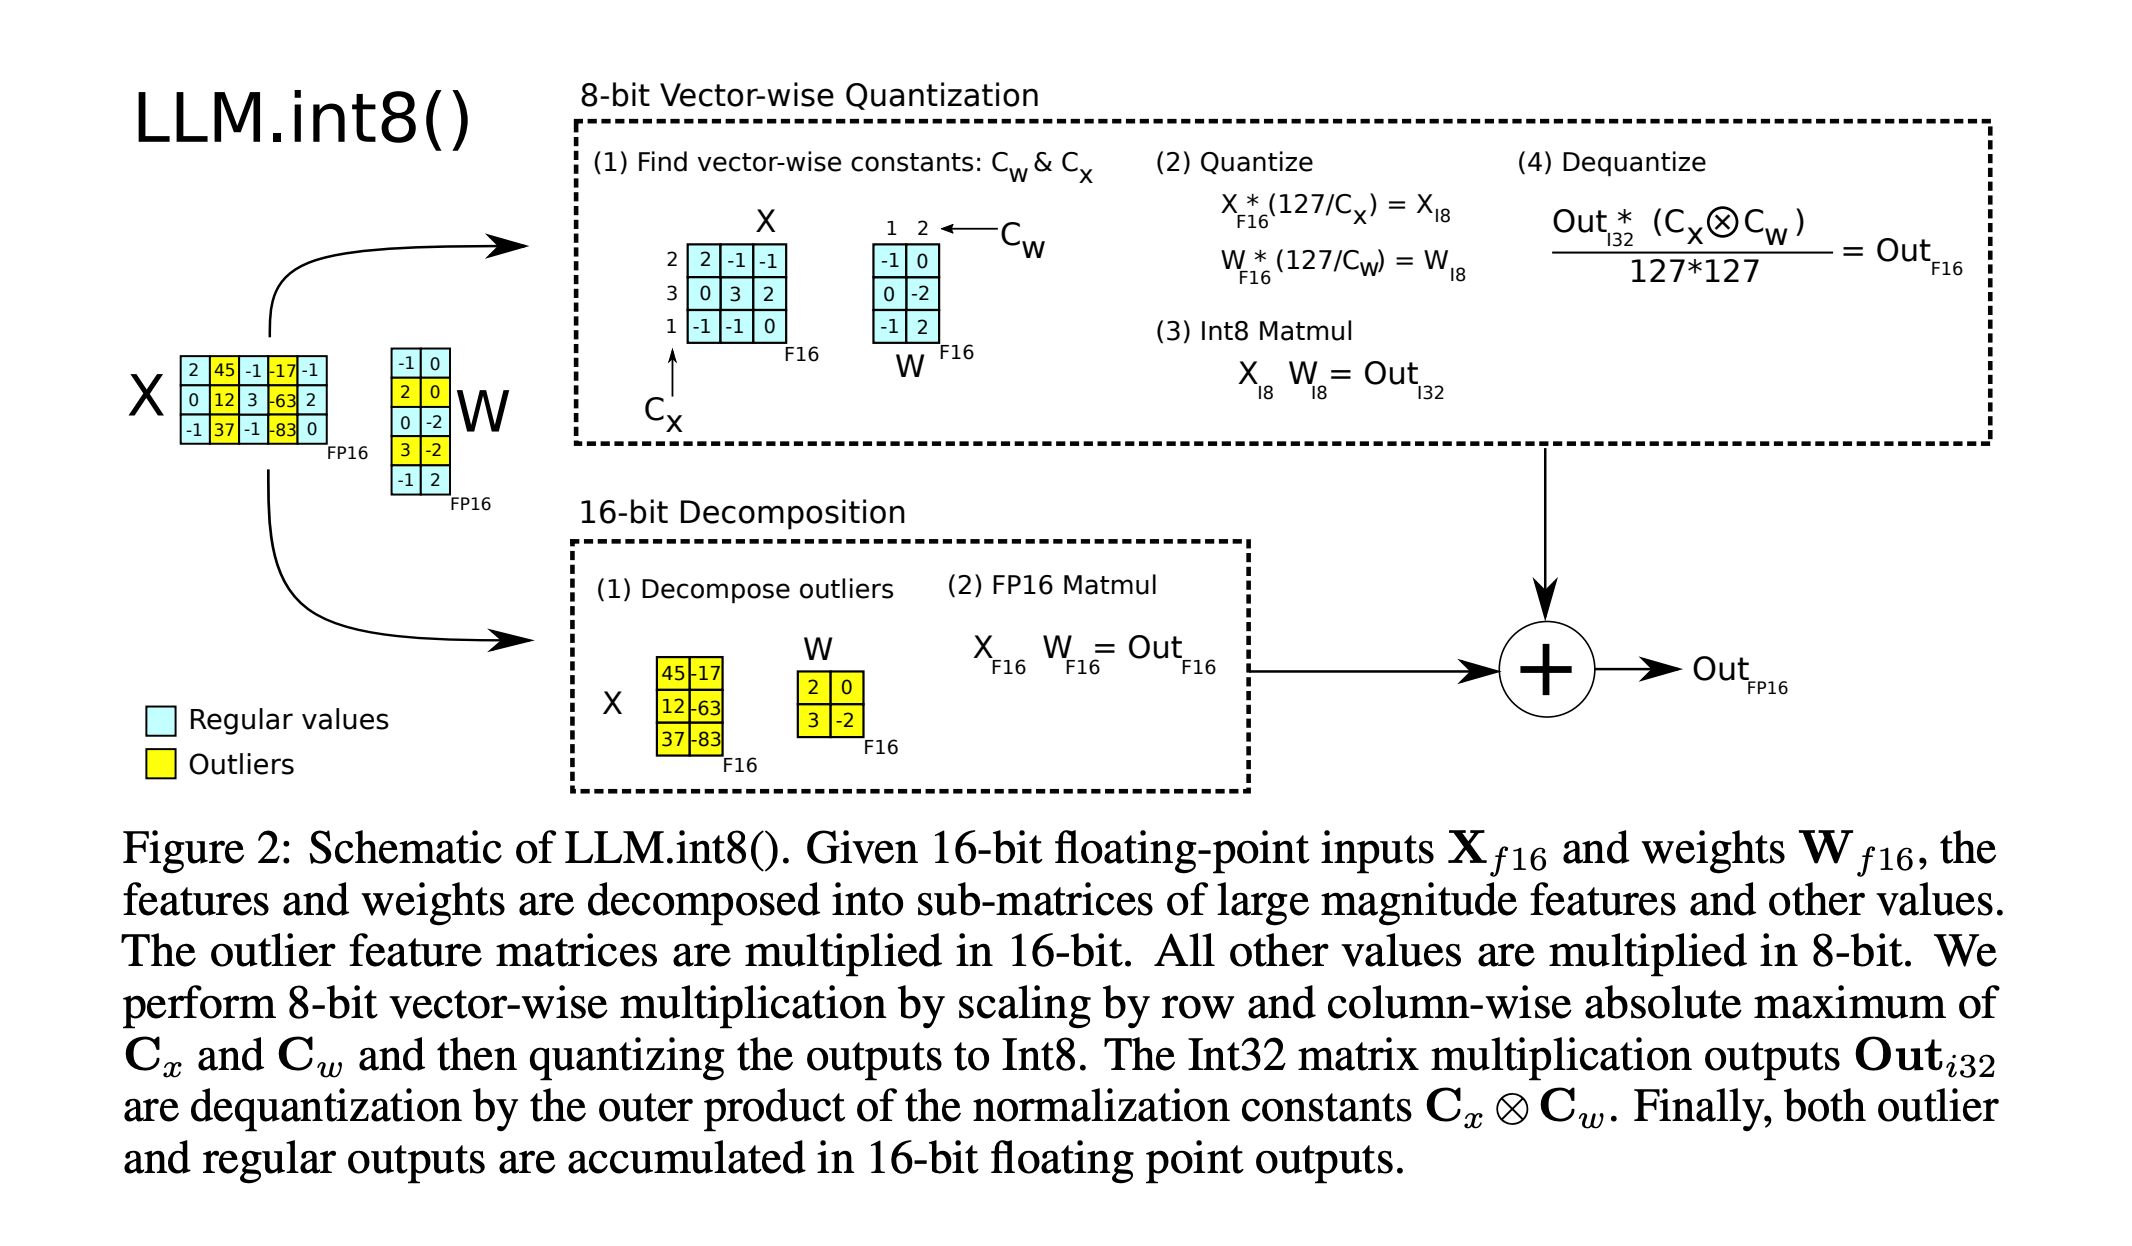

In [34]:
Image('../imgs/llm-int8.png')

In [67]:
# 列为特征，行为样本
X = np.asarray([[2, 45, -1, -17, -1], 
                [0, 12, 3, -63, 2], 
                [-1, 37, -1, -83, 0]], )
W = np.asarray([[-1, 0], 
                [2, 0], 
                [0, -2], 
                [3, -2], 
                [-1, 2]])

In [68]:
# (3, 5) * (5, 2) ==> (3, 2)
# ground truth
X.dot(W)

array([[  38,   34],
       [-167,  124],
       [-174,  168]])

In [70]:
X_reg = X[:, [0, 2, 4]]
W_reg = W[[0, 2, 4], :]

X_out = X[:, [1, 3]]
W_out = W[[1, 3], :]

### regular parts (small values) => 8bit quant

In [71]:
X_reg

array([[ 2, -1, -1],
       [ 0,  3,  2],
       [-1, -1,  0]])

In [72]:
np.max(np.abs(X_reg), axis=0)

array([2, 3, 2])

In [73]:
W_reg

array([[-1,  0],
       [ 0, -2],
       [-1,  2]])

####  vector-wise constants

In [74]:
# 行最大（振幅）
Cx = np.max(np.abs(X_reg), axis=1)[:, np.newaxis]
# 列最大（振幅）
Cw = np.max(np.abs(W_reg), axis=0)[np.newaxis, :]

In [76]:
Cw

array([[1, 2]])

#### quantize

In [77]:
# element-wise 乘法
X_i8 = X_reg * (127/Cx)
W_i8 = W_reg * (127/Cw)

#### int8 matmul

In [78]:
Out_i32 = X_i8.dot(W_i8)

#### dequant

In [79]:
Cx.shape

(3, 1)

In [80]:
Cw.shape

(1, 2)

In [41]:
np.kron(Cx, Cw)

array([[2, 4],
       [3, 6],
       [1, 2]])

In [81]:
# element-wise 乘法
Out_f16_1 = Out_i32 * (np.kron(Cx, Cw)) / (127*127)
Out_f16_1

array([[-1.,  0.],
       [-2., -2.],
       [ 1.,  2.]])

### 16-bit

In [84]:
Out_f16_2 = X_out.dot(W_out)

In [85]:
Out_f16_1 + Out_f16_2

array([[  38.,   34.],
       [-167.,  124.],
       [-174.,  168.]])

## huggingface 中的使用

In [36]:
# pip install bitsandbytes
# pip install transformers
# pip install accelerate

In [37]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [40]:
import os
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'

In [43]:
MAX_NEW_TOKENS = 128
ckpt = 'facebook/opt-6.7b'

sample = 'hello, who are you?'
tokenizer = AutoTokenizer.from_pretrained(ckpt)
input_ids = tokenizer(sample, return_tensors='pt').input_ids
input_ids

tensor([[    2, 42891,     6,    54,    32,    47,   116]])

In [48]:
model = AutoModelForCausalLM.from_pretrained(ckpt, 
                                             device_map='auto', load_in_8bit=True, )

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/whaow/anaconda3/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA SETUP: CUDA runtime path found: /home/whaow/anaconda3/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.9
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /home/whaow/anaconda3/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [49]:
generated_ids = model.generate(input_ids, max_length=MAX_NEW_TOKENS)
tokenizer.decode(generated_ids[0], skip_special_tokens=True)

/home/whaow/anaconda3/lib/python3.10/site-packages/transformers/generation/utils.py:1405: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


"hello, who are you?\nI'm a guy who's been playing for a while and I'm looking for a clan to join. I'm not a very good player but I'm trying to get better. I'm not very good at the game but I'm trying to get better. I'm not very good at the game but I'm trying to get better. I'm not very good at the game but I'm trying to get better. I'm not very good at the game but I'm trying to get better.\nI'm not very good at the game but I'm trying to get better. I'm not"

In [52]:
for i, para in enumerate(model.named_parameters()):
#     print(f'{i}, {para[0]}\t {para[1].device} \t{para[1].dtype}')
    print(f'{i}:{para[0]}, \t {para[1].device} \t{para[1].dtype}')

0:model.decoder.embed_tokens.weight, 	 cuda:0 	torch.float16
1:model.decoder.embed_positions.weight, 	 cuda:0 	torch.float16
2:model.decoder.final_layer_norm.weight, 	 cuda:0 	torch.float16
3:model.decoder.final_layer_norm.bias, 	 cuda:0 	torch.float16
4:model.decoder.layers.0.self_attn.k_proj.weight, 	 cuda:0 	torch.int8
5:model.decoder.layers.0.self_attn.k_proj.bias, 	 cuda:0 	torch.float16
6:model.decoder.layers.0.self_attn.v_proj.weight, 	 cuda:0 	torch.int8
7:model.decoder.layers.0.self_attn.v_proj.bias, 	 cuda:0 	torch.float16
8:model.decoder.layers.0.self_attn.q_proj.weight, 	 cuda:0 	torch.int8
9:model.decoder.layers.0.self_attn.q_proj.bias, 	 cuda:0 	torch.float16
10:model.decoder.layers.0.self_attn.out_proj.weight, 	 cuda:0 	torch.int8
11:model.decoder.layers.0.self_attn.out_proj.bias, 	 cuda:0 	torch.float16
12:model.decoder.layers.0.self_attn_layer_norm.weight, 	 cuda:0 	torch.float16
13:model.decoder.layers.0.self_attn_layer_norm.bias, 	 cuda:0 	torch.float16
14:model.deco